In [1]:
import numpy as np
import pickle
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
vectors_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_vectors.npy')
labels_baseline = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/baseline_labels.npy')
vectors_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_vectors.npy')
labels_embeddings = np.load('/home/ev357/tcbench/src/fingerprinting/artifacts-mirage19/embeddings_labels.npy')

In [3]:
within_class_file = "/home/ev357/rds/hpc-work/baseline_min_within.pkl"
between_class_file = "/home/ev357/rds/hpc-work/baseline_min_between.pkl"

with open(within_class_file, 'rb') as f:
    min_within_baseline = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_baseline = pickle.load(f)

In [4]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_min_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_min_between.npy"

with open(within_class_file, 'rb') as f:
    min_within_embeddings = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_embeddings = pickle.load(f)

In [5]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_min_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_min_between.npy"

with open(within_class_file, 'rb') as f:
    min_within_embeddings_cosine = pickle.load(f)
with open(between_class_file, 'rb') as f:
    min_between_embeddings_cosine = pickle.load(f)

In [6]:
within_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_max_within.npy"
between_class_file = "/home/ev357/rds/hpc-work/embeddings_cosine_similarity_max_between.npy"

with open(within_class_file, 'rb') as f:
    max_within_embeddings_cosine_similarity = pickle.load(f)
with open(between_class_file, 'rb') as f:
    max_between_embeddings_cosine_similarity = pickle.load(f)

In [7]:
def calculate_statistics_per_class(distances, percentiles=range(1, 101)):
    stats_per_class = {}

    for label, distance_array in distances.items():
        flattened_distances = distance_array.flatten()

        stats = {
            "min": np.min(flattened_distances),
            "avg": np.mean(flattened_distances),
            "max": np.max(flattened_distances),
            "stddev": np.std(flattened_distances),
            "variance": np.var(flattened_distances),
            "percentiles": {p: np.percentile(flattened_distances, p) for p in percentiles},
        }

        stats_per_class[label] = stats

    return stats_per_class

In [8]:
stats_min_within_baseline = calculate_statistics_per_class(min_within_baseline)
stats_min_between_baseline = calculate_statistics_per_class(min_between_baseline)

In [9]:
stats_min_within_embeddings = calculate_statistics_per_class(min_within_embeddings)
stats_min_between_embeddings = calculate_statistics_per_class(min_between_embeddings)

In [10]:
stats_min_within_embeddings_cosine = calculate_statistics_per_class(min_within_embeddings_cosine)
stats_min_between_embeddings_cosine = calculate_statistics_per_class(min_between_embeddings_cosine)

In [11]:
stats_max_within_embeddings_cosine_similarity = calculate_statistics_per_class(max_within_embeddings_cosine_similarity)
stats_max_between_embeddings_cosine_similarity = calculate_statistics_per_class(max_between_embeddings_cosine_similarity)

In [12]:
def plot_cdfs(stats_within, stats_between, title_prefix, name, xlim=1, reverse=False):
    fig, axes = plt.subplots(4, 5, figsize=(20, 15))
    axes = axes.flatten()

    for i, label in enumerate(stats_within.keys()):
        if i >= len(axes):
            break

        ax = axes[i]
        within_distances = stats_within[label]["percentiles"].values()
        between_distances = stats_between[label]["percentiles"].values()

        within_sorted = np.sort(list(within_distances))
        between_sorted = np.sort(list(between_distances))
        within_cdf = np.arange(1, len(within_sorted) + 1) / len(within_sorted)
        between_cdf = np.arange(1, len(between_sorted) + 1) / len(between_sorted)

        ax.plot(within_sorted, within_cdf, label="Within class", color="blue")
        ax.plot(between_sorted, between_cdf, label="Between class", color="red")

        ax.set_title(f"{title_prefix} Class {label}")
        ax.set_xlabel("Distance")
        ax.set_ylabel("CDF")
        ax.set_xlim(0, xlim)

        if reverse:
            ax.set_xlabel('Similarity')
            ax.set_xlim(1-xlim,1)
        
        ax.legend()

    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig(f"/home/ev357/tcbench/src/fingerprinting/plots/{name}.png")
    plt.show()

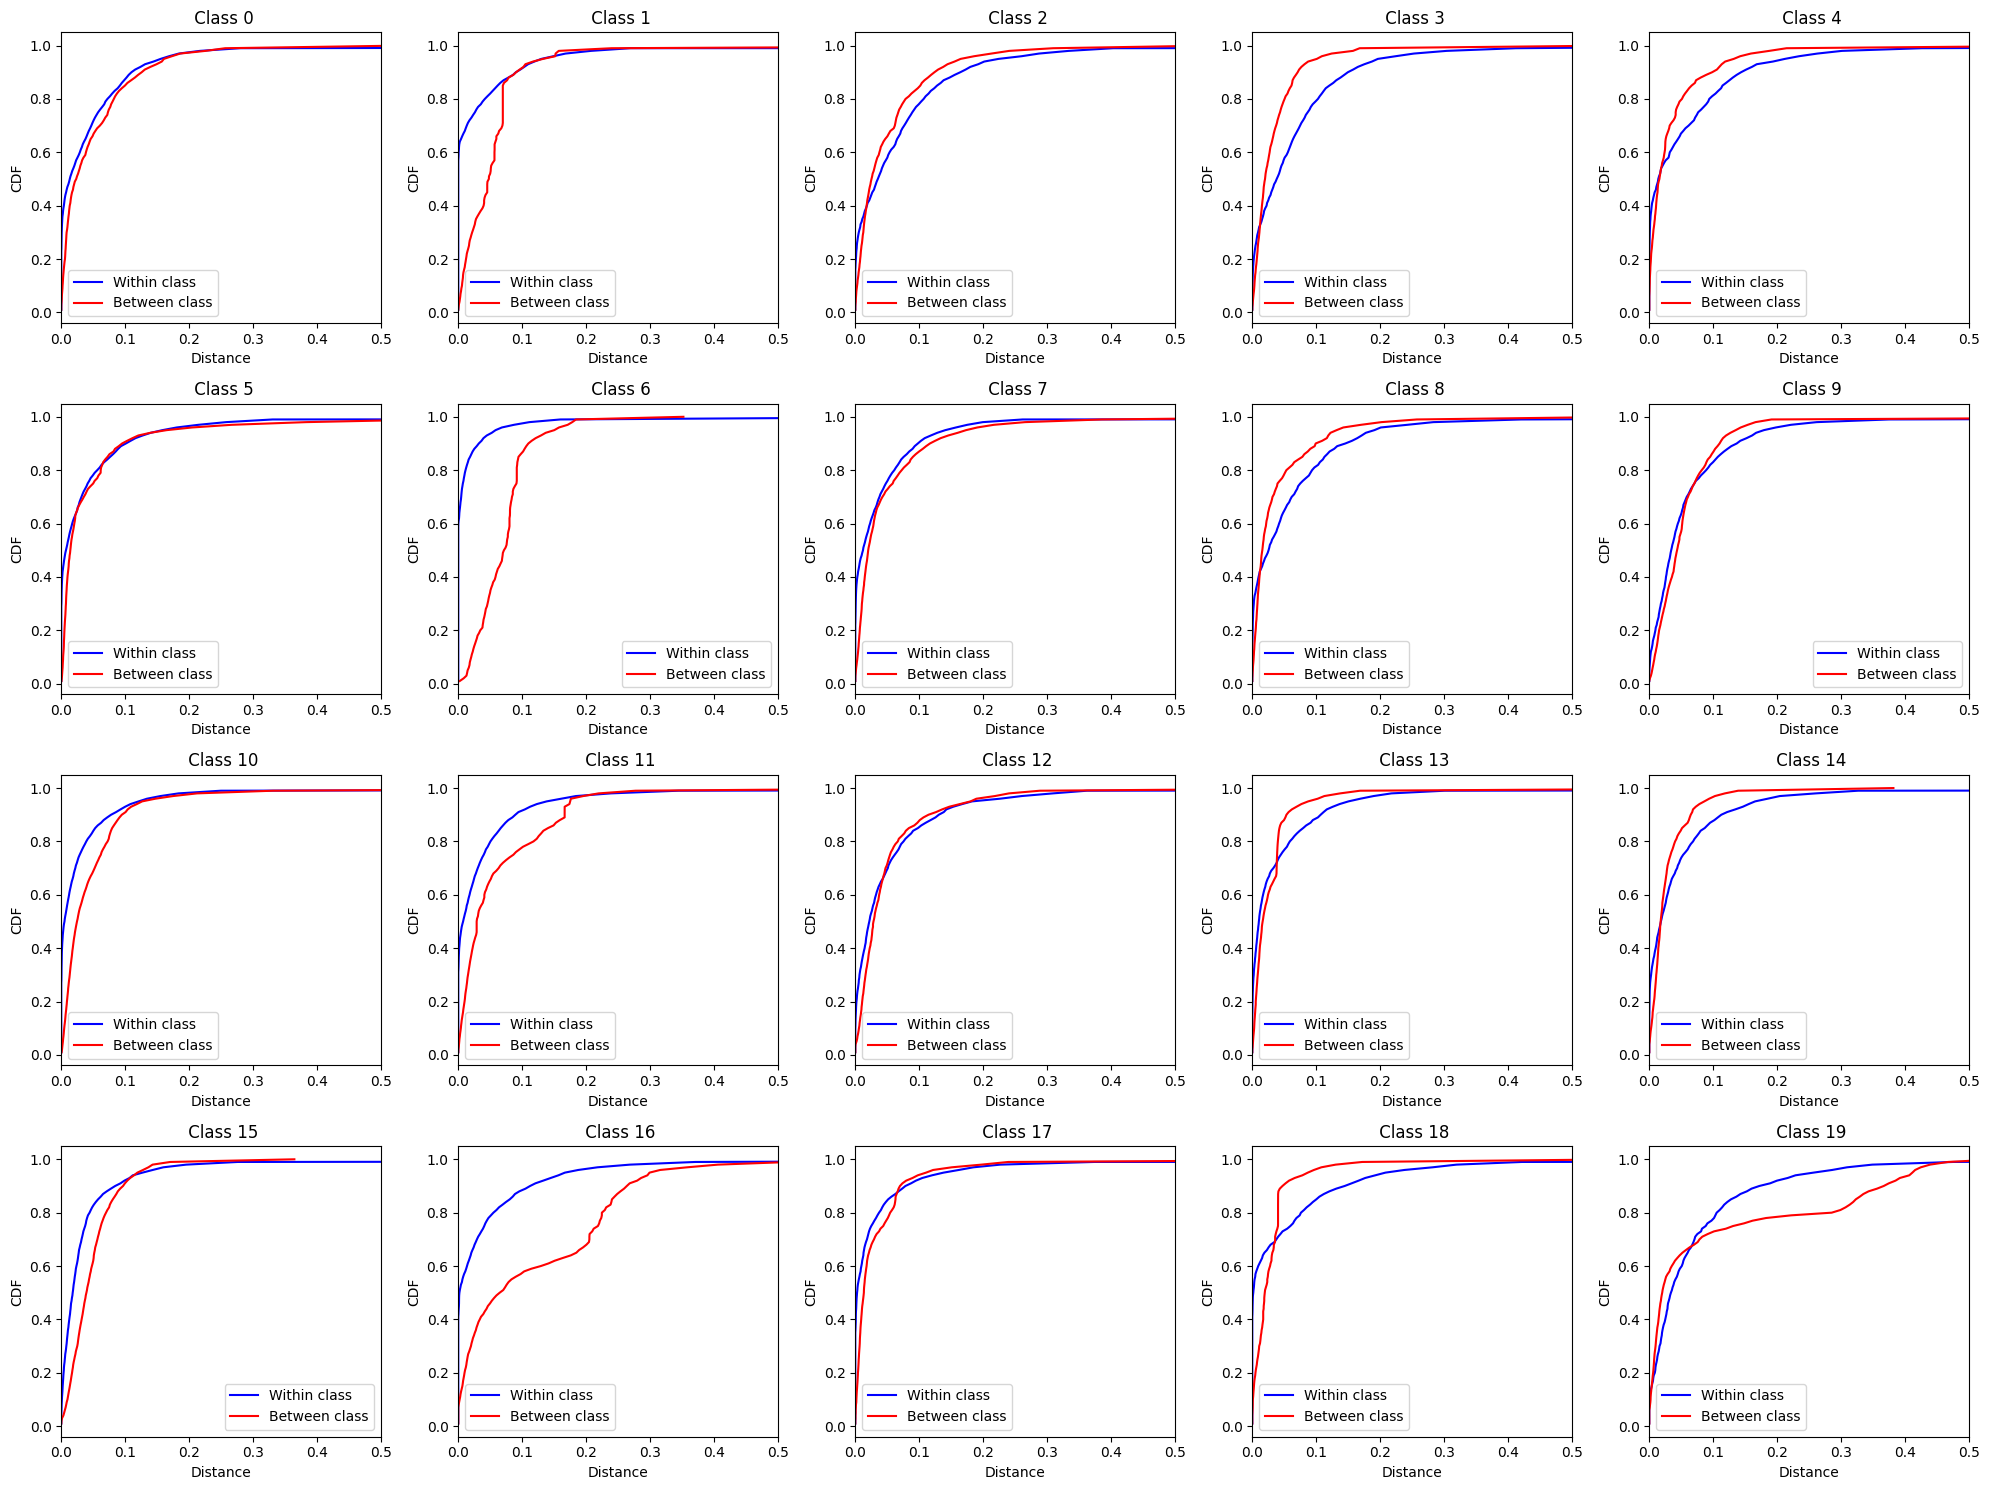

In [13]:
plot_cdfs(stats_min_within_baseline, stats_min_between_baseline, title_prefix="", name="min_baseline", xlim=0.5)

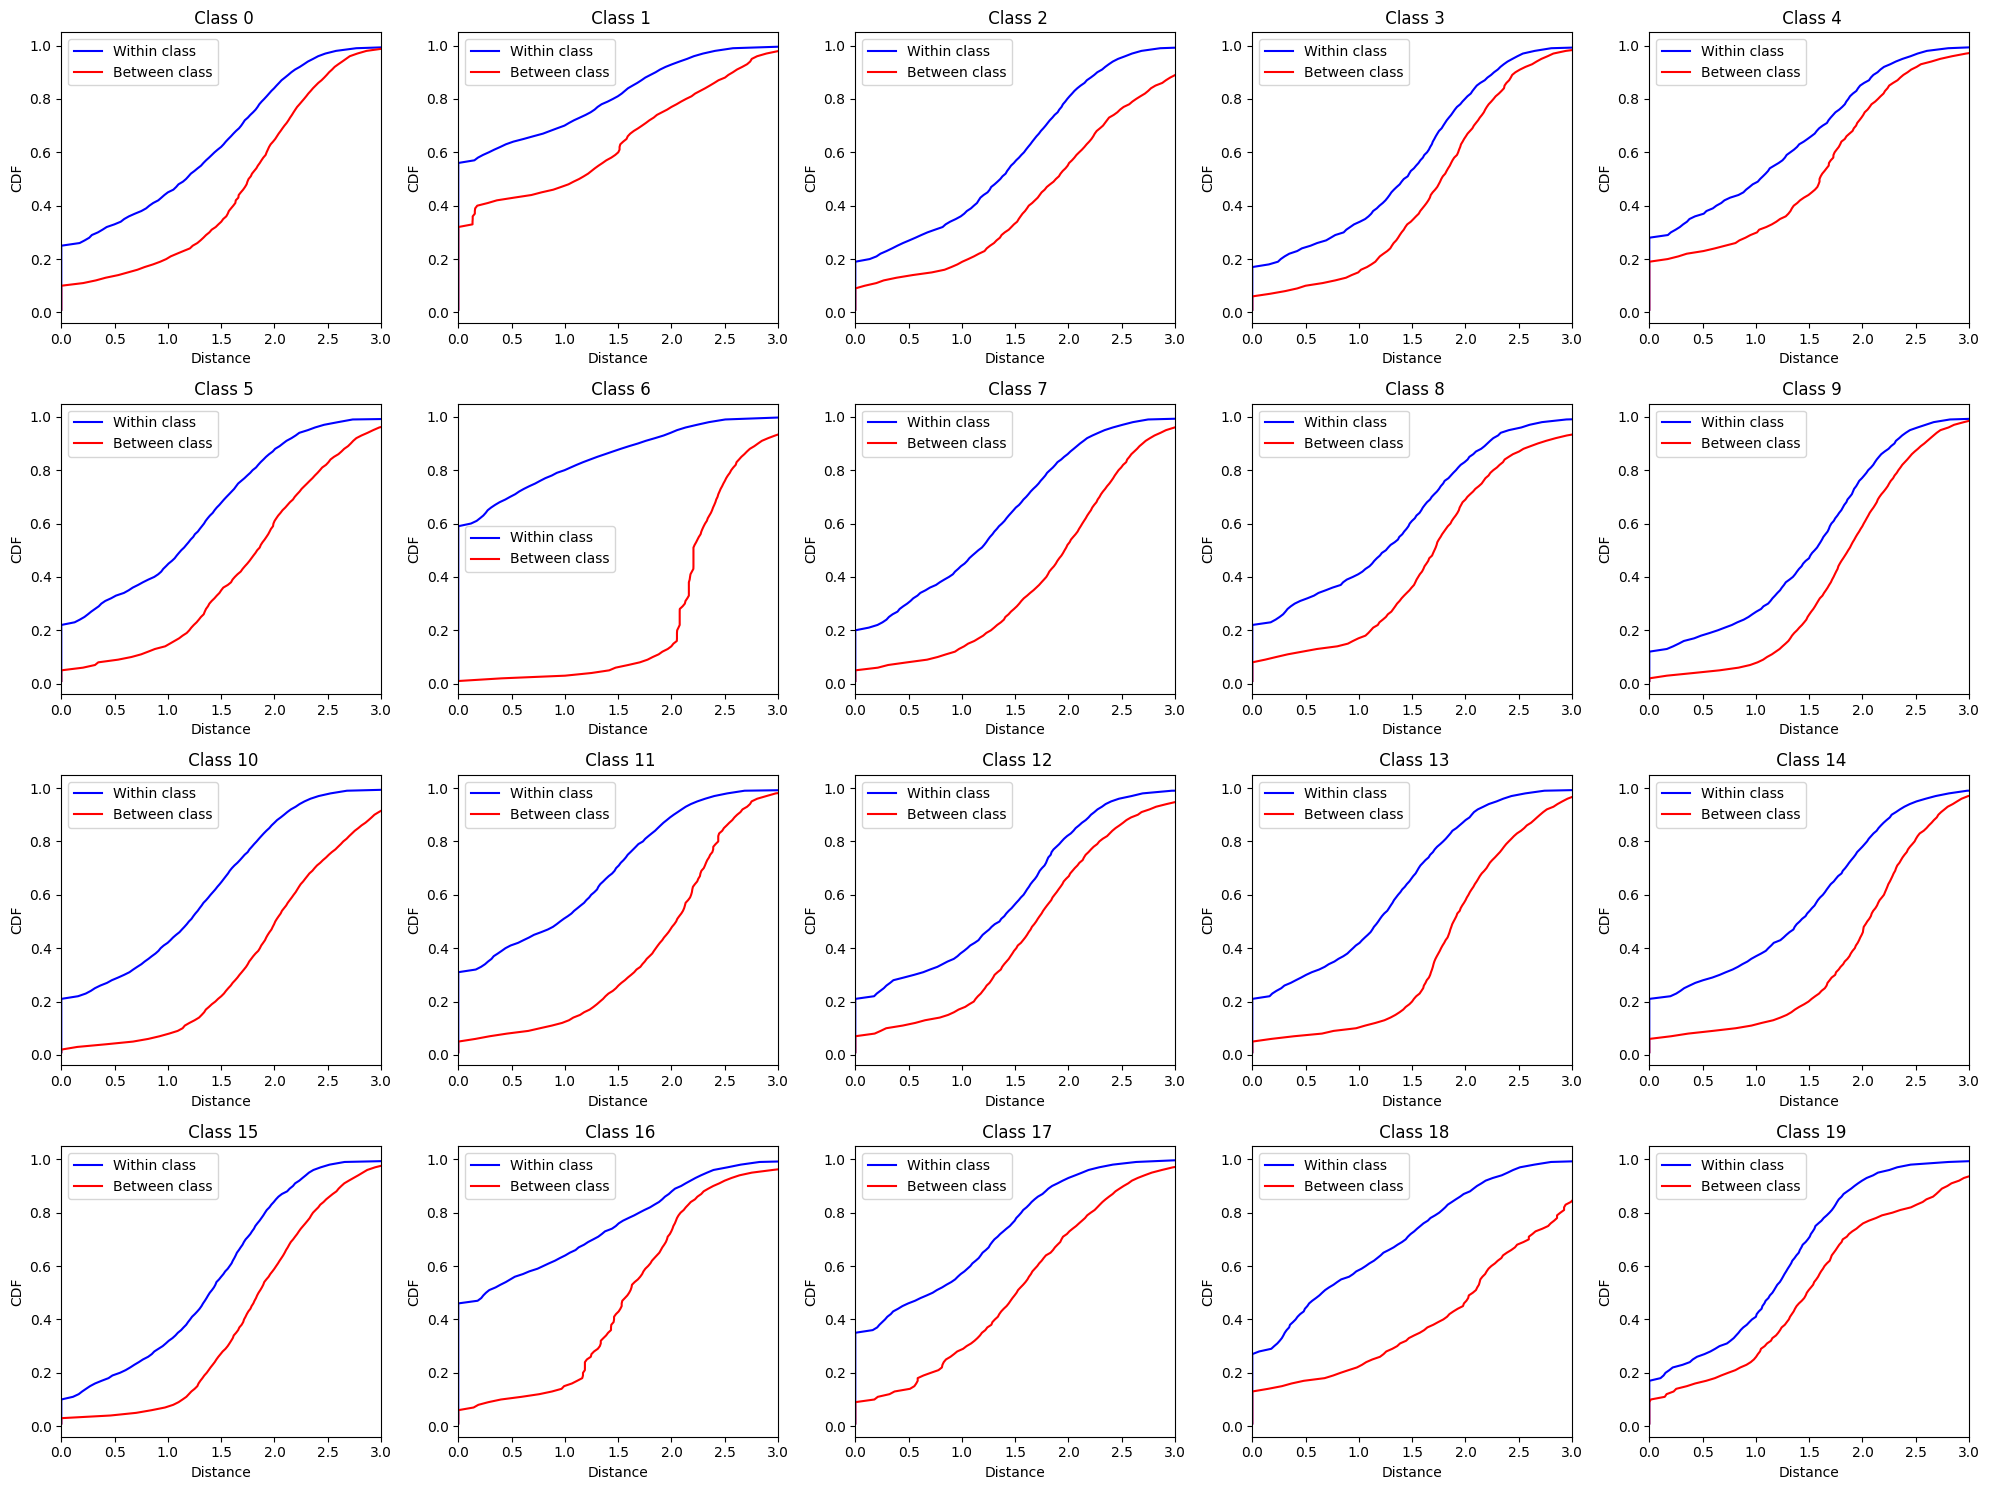

In [14]:
plot_cdfs(stats_min_within_embeddings, stats_min_between_embeddings, title_prefix="", name="min_embeddings", xlim=3)

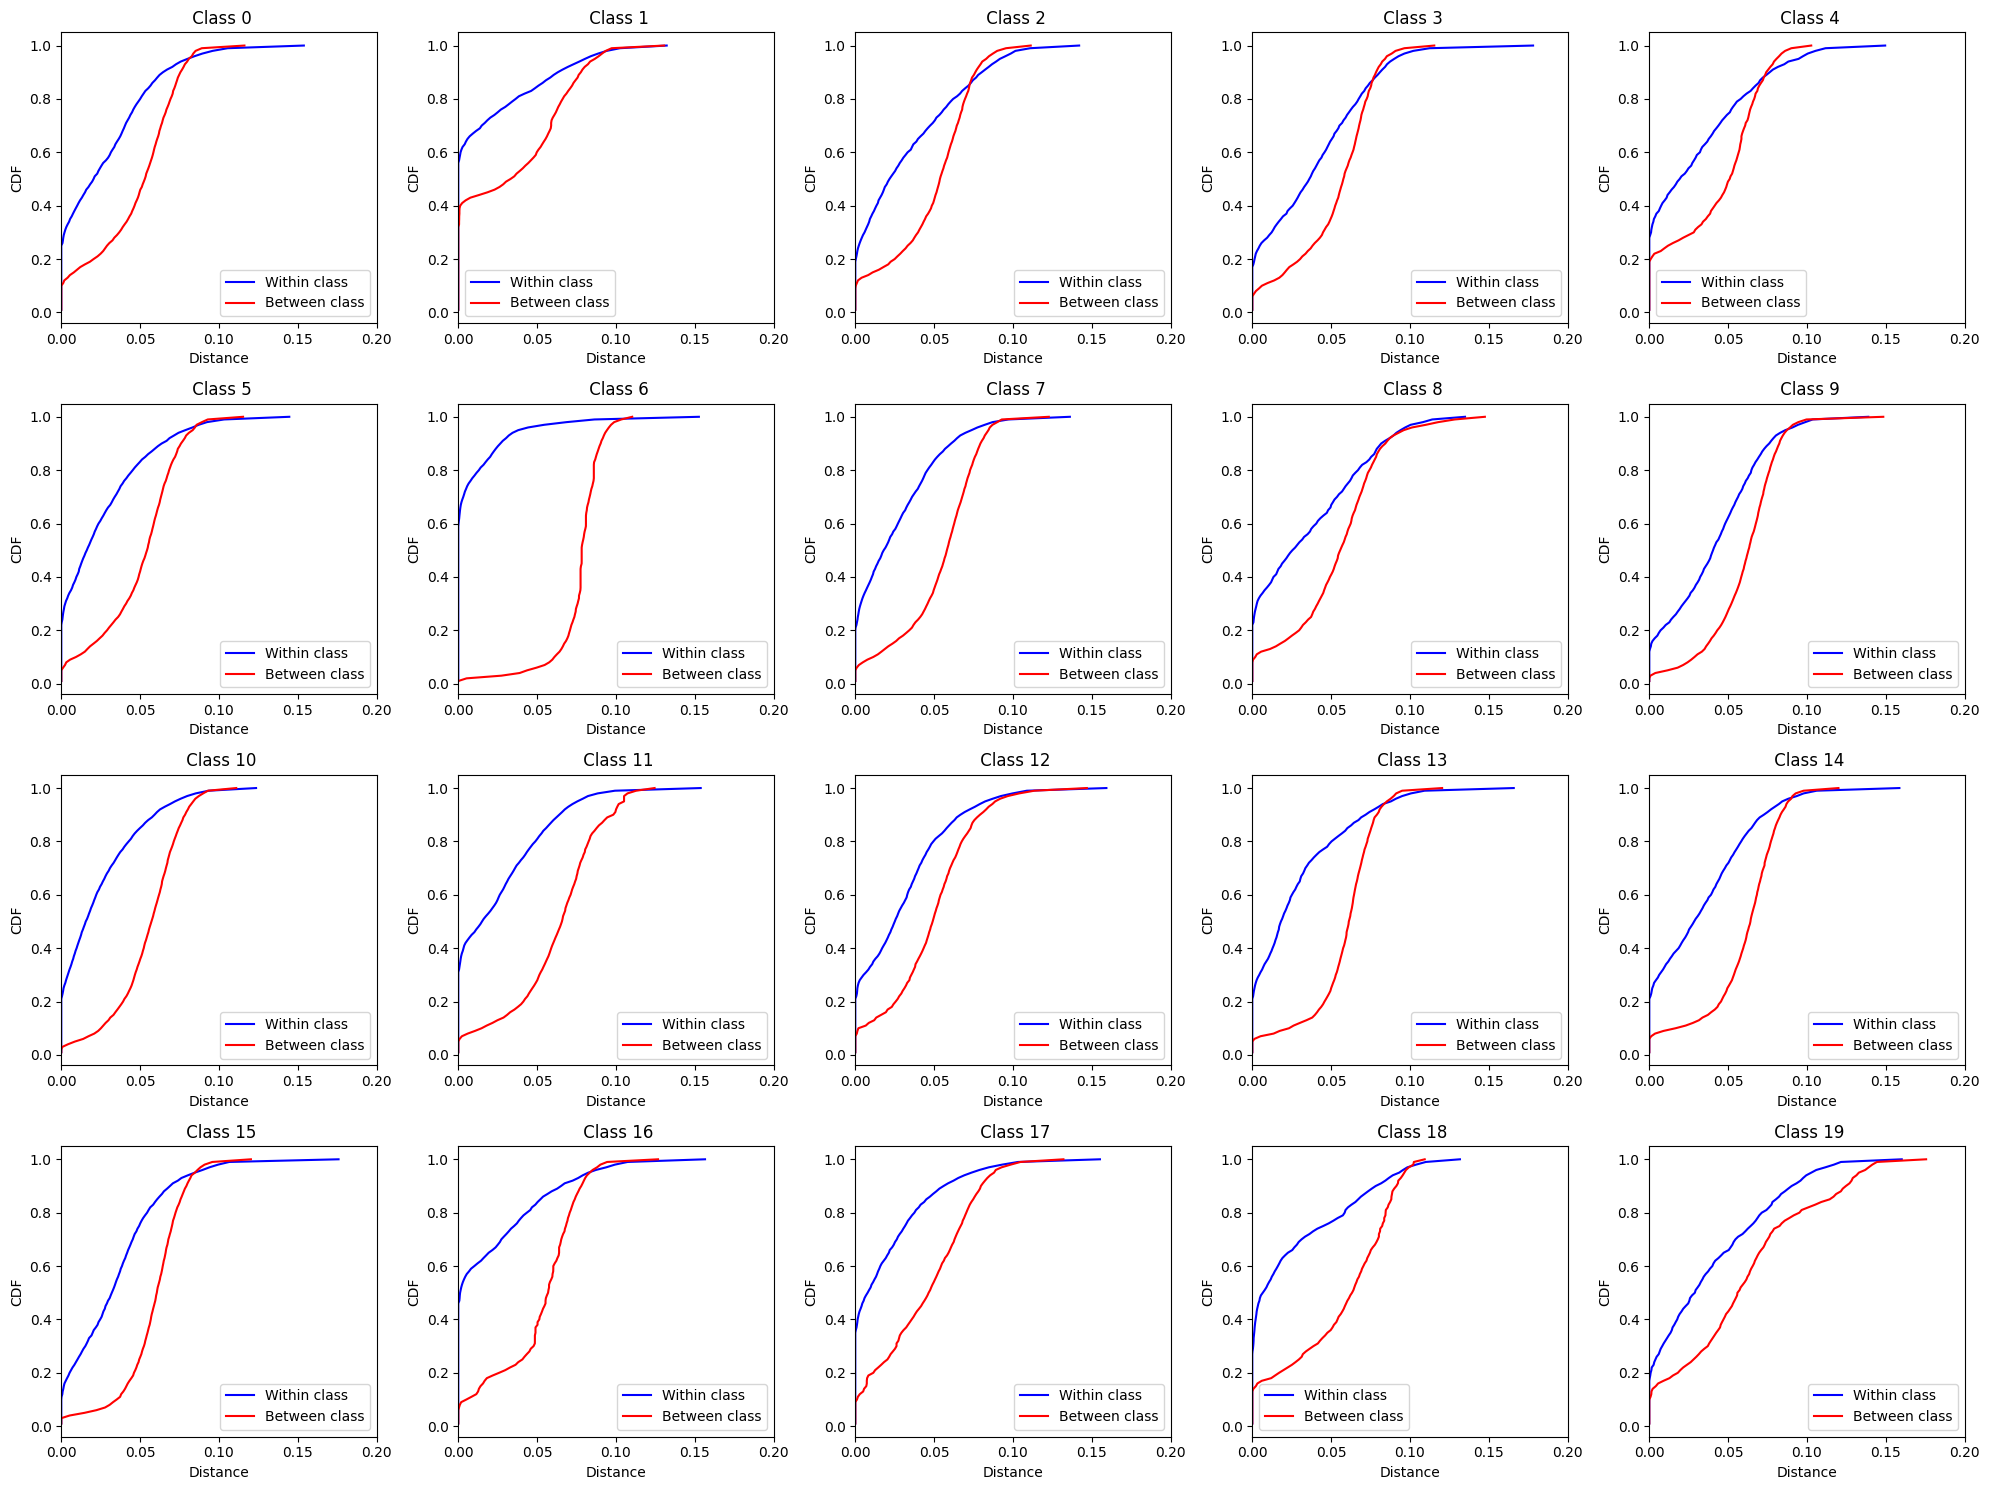

In [15]:
plot_cdfs(stats_min_within_embeddings_cosine, stats_min_between_embeddings_cosine, title_prefix="", name="min_embeddings_cosine", xlim=0.2)

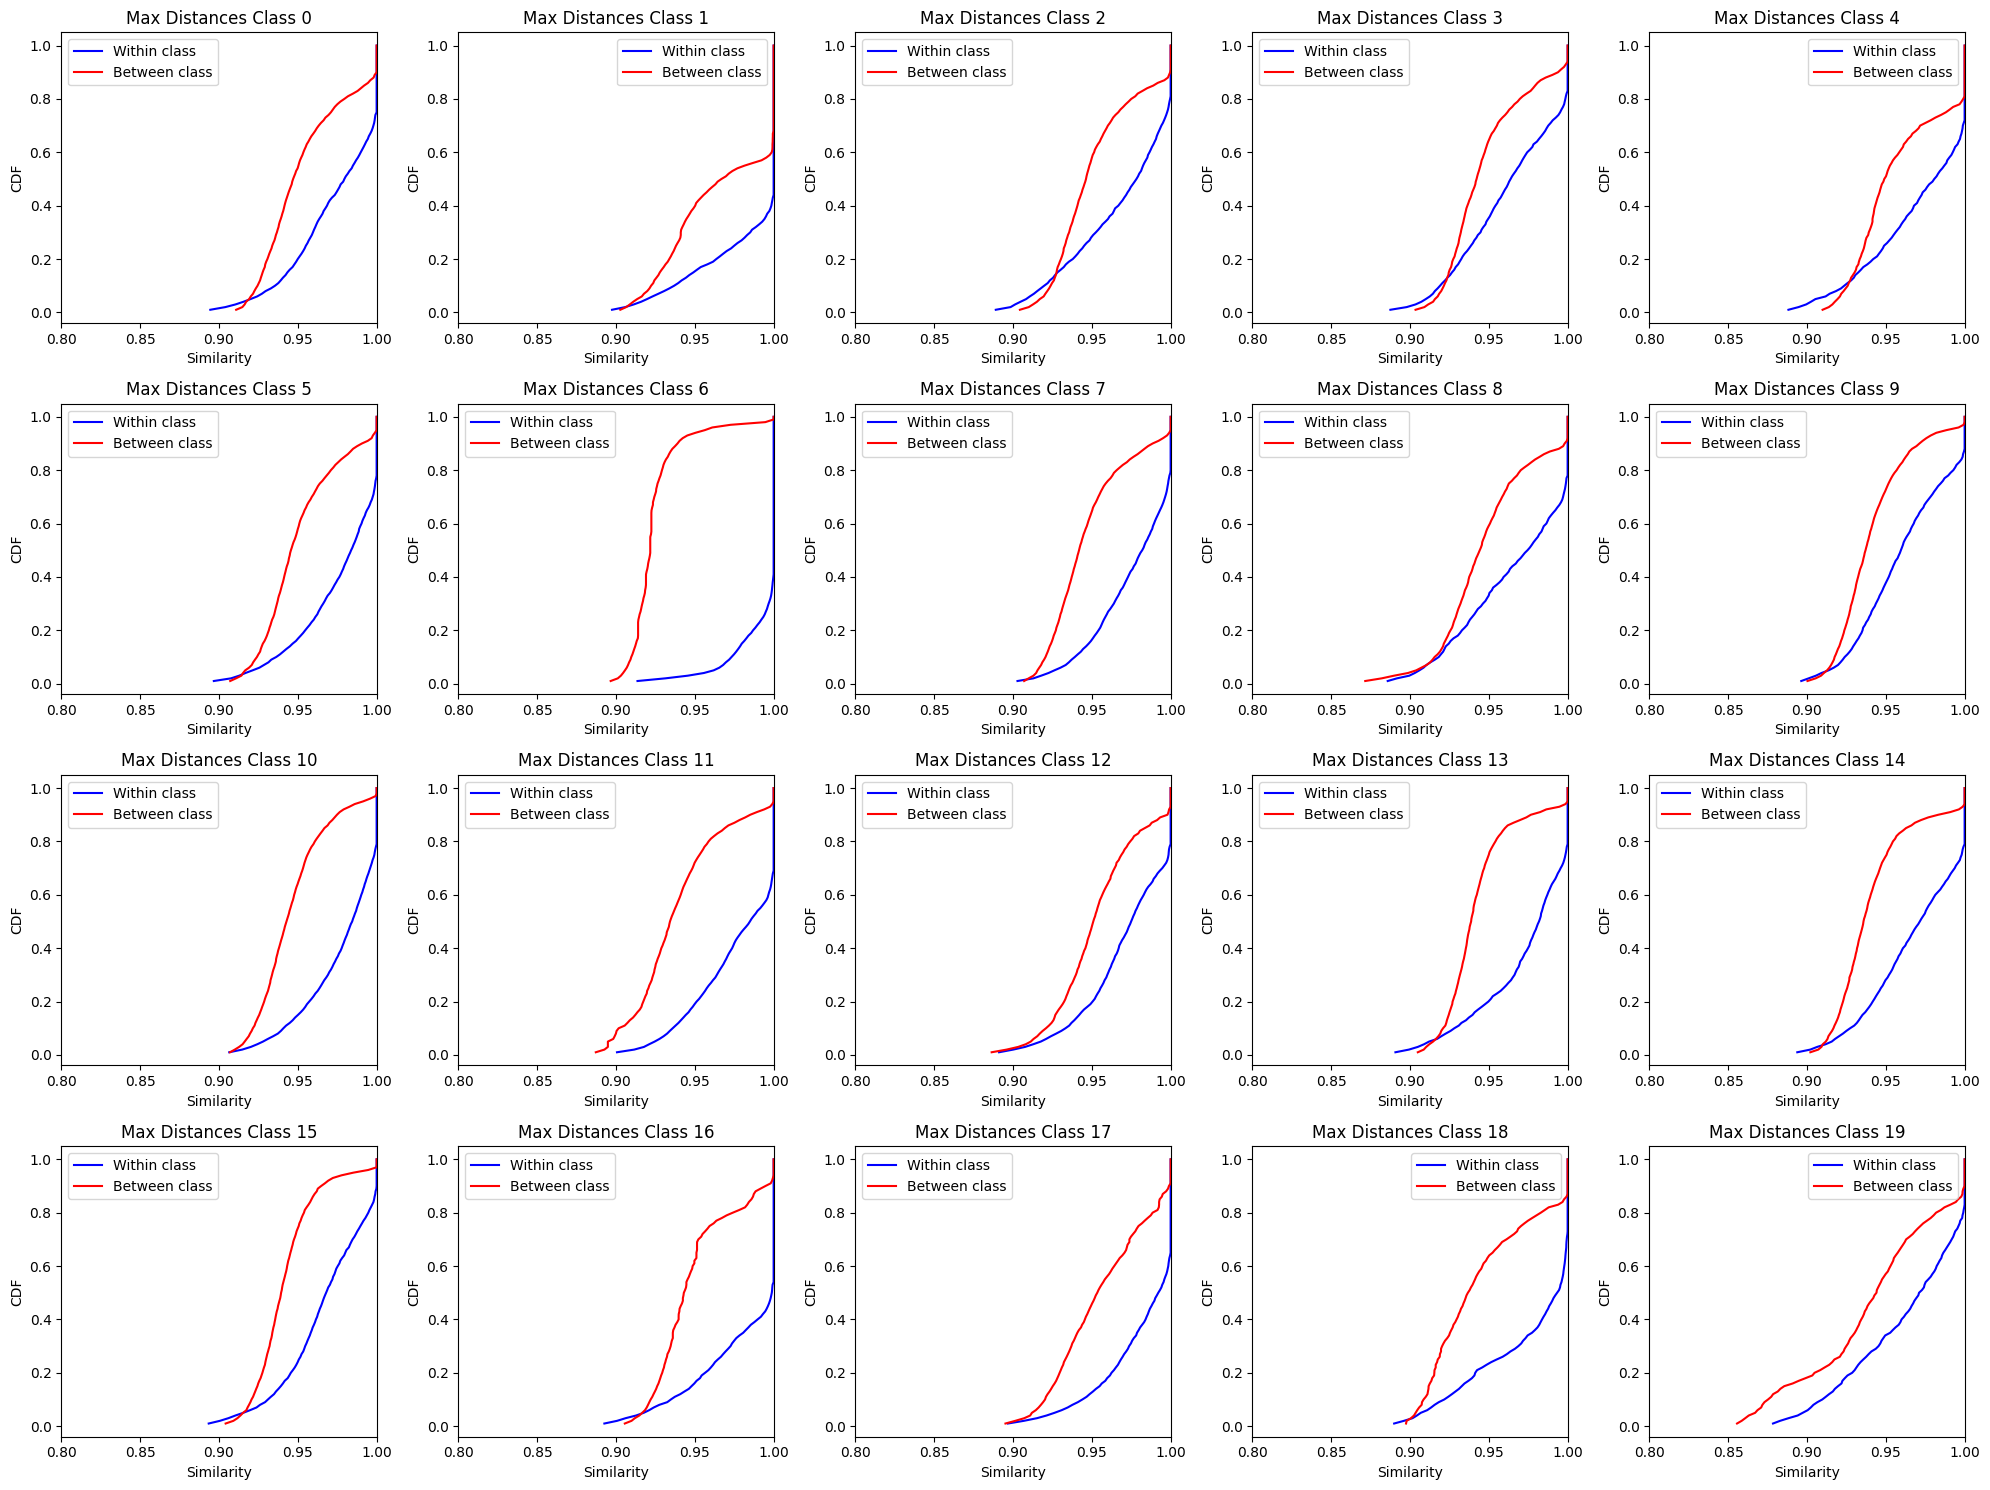

In [16]:
plot_cdfs(stats_max_within_embeddings_cosine_similarity, stats_max_between_embeddings_cosine_similarity, title_prefix="Max Distances", name="max_embeddings_cosine", xlim=0.2, reverse=True)

In [17]:
def output_statistics(stats_within):
    rows = []

    for label in stats_within.keys():
        row = {
            "Class": label,
            "Min": stats_within[label]["min"],
            "Avg": stats_within[label]["avg"],
            "Max": stats_within[label]["max"],
            "StdDev": stats_within[label]["stddev"],
            "10th %": stats_within[label]["percentiles"][10],
            "25th %": stats_within[label]["percentiles"][25],
            "50th %": stats_within[label]["percentiles"][50],
            "75th %": stats_within[label]["percentiles"][75],
            "90th %": stats_within[label]["percentiles"][95],
            "99th %": stats_within[label]["percentiles"][99]
        }
        rows.append(row)

    df = pd.DataFrame(rows)
    df = df.round(3)
    print(df.to_string(index=False))

In [18]:
output_statistics(stats_min_within_baseline)

 Class  Min   Avg    Max  StdDev  10th %  25th %  50th %  75th %  90th %  99th %
     0  0.0 0.041  3.068   0.079   0.000   0.000   0.013   0.058   0.155   0.280
     1  0.0 0.030 13.104   0.220   0.000   0.000   0.000   0.026   0.130   0.269
     2  0.0 0.068  4.102   0.151   0.000   0.002   0.035   0.089   0.224   0.403
     3  0.0 0.062  0.955   0.083   0.000   0.005   0.038   0.087   0.196   0.412
     4  0.0 0.054  1.530   0.100   0.000   0.000   0.014   0.076   0.212   0.426
     5  0.0 0.038  6.022   0.127   0.000   0.000   0.007   0.041   0.158   0.330
     6  0.0 0.012  0.845   0.038   0.000   0.000   0.000   0.007   0.058   0.160
     7  0.0 0.038  5.944   0.130   0.000   0.000   0.012   0.048   0.141   0.262
     8  0.0 0.056  1.488   0.104   0.000   0.001   0.025   0.075   0.191   0.420
     9  0.0 0.059  1.884   0.090   0.002   0.015   0.034   0.070   0.179   0.375
    10  0.0 0.027  2.535   0.062   0.000   0.000   0.005   0.029   0.121   0.250
    11  0.0 0.035  2.780   0

In [19]:
output_statistics(stats_min_within_embeddings)

 Class  Min   Avg   Max  StdDev  10th %  25th %  50th %  75th %  90th %  99th %
     0  0.0 1.082 3.521   0.846     0.0   0.000   1.171   1.799   2.362   2.767
     1  0.0 0.576 3.339   0.793     0.0   0.000   0.000   1.242   2.146   2.576
     2  0.0 1.226 3.575   0.843     0.0   0.395   1.361   1.899   2.465   2.861
     3  0.0 1.270 3.666   0.817     0.0   0.547   1.422   1.883   2.440   2.805
     4  0.0 1.013 3.426   0.857     0.0   0.000   1.040   1.747   2.375   2.804
     5  0.0 1.048 4.443   0.801     0.0   0.217   1.126   1.659   2.313   2.734
     6  0.0 0.445 3.190   0.705     0.0   0.000   0.000   0.721   2.052   2.505
     7  0.0 1.083 3.677   0.799     0.0   0.316   1.155   1.720   2.339   2.747
     8  0.0 1.132 3.814   0.850     0.0   0.256   1.253   1.790   2.407   2.946
     9  0.0 1.394 3.627   0.776     0.0   0.931   1.552   1.956   2.445   2.821
    10  0.0 1.099 3.641   0.786     0.0   0.315   1.197   1.720   2.282   2.680
    11  0.0 0.925 4.420   0.822     0.0 

In [20]:
output_statistics(stats_min_within_embeddings_cosine)

 Class  Min   Avg   Max  StdDev  10th %  25th %  50th %  75th %  90th %  99th %
     0  0.0 0.027 0.154   0.027     0.0   0.000   0.020   0.045   0.080   0.105
     1  0.0 0.017 0.132   0.028     0.0   0.000   0.000   0.025   0.080   0.102
     2  0.0 0.032 0.142   0.032     0.0   0.002   0.022   0.055   0.092   0.111
     3  0.0 0.038 0.178   0.031     0.0   0.005   0.036   0.061   0.090   0.112
     4  0.0 0.029 0.150   0.032     0.0   0.000   0.019   0.051   0.095   0.112
     5  0.0 0.024 0.145   0.026     0.0   0.001   0.016   0.039   0.079   0.103
     6  0.0 0.008 0.153   0.017     0.0   0.000   0.000   0.007   0.038   0.086
     7  0.0 0.025 0.136   0.025     0.0   0.002   0.018   0.041   0.074   0.097
     8  0.0 0.034 0.135   0.033     0.0   0.001   0.025   0.061   0.094   0.114
     9  0.0 0.040 0.139   0.028     0.0   0.015   0.040   0.061   0.086   0.104
    10  0.0 0.023 0.124   0.024     0.0   0.001   0.016   0.036   0.072   0.093
    11  0.0 0.024 0.154   0.027     0.0 